In [13]:
from datasets import load_from_disk

In [14]:
dataset=load_from_disk('/shared/how2_all.dataset').with_format('torch')

In [15]:
dataset[392]['vid'].shape

torch.Size([2048])

In [16]:
# Train string encoders
en_data = [" ".join(x) for x in dataset['en']]
pt_data = [" ".join(x) for x in dataset['pt']]
sm_data = [" ".join(x) for x in dataset['sm'] if x]

In [17]:
#en_training_corpus = (
#    en_data[i : i + 1000]
#    for i in range(0, len(en_data), 1000)
#)

In [18]:
from transformers import AutoTokenizer

#old_tokenizer = AutoTokenizer.from_pretrained("gpt2")
#old_tokenizer.encode(" ".join(dataset[0]['sm']))

In [19]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

trainer = BpeTrainer(special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"],
                    vocab_size=8192)

In [20]:
tokenizer.train_from_iterator(sm_data,trainer)

In [21]:
tokenizer.save('sm_tokenizer')

In [22]:
tokenizer.get_vocab_size()
tokenizer.get_vocab()

{'ultra': 5615,
 'bin': 2770,
 'related': 2847,
 'ni': 242,
 'celain': 2597,
 'marks': 4117,
 'alligators': 7189,
 'electronics': 2379,
 'abstra': 5494,
 'unks': 7636,
 'step': 667,
 'main': 909,
 'tenkan': 5503,
 'known': 2547,
 'roun': 2892,
 'cand': 2676,
 'sel': 517,
 'raise': 3186,
 'explained': 6122,
 'compost': 4113,
 'letting': 4322,
 'stationary': 4763,
 'esive': 6016,
 'amphibians': 7392,
 'explan': 5313,
 'wakeboard': 7478,
 'pageant': 4274,
 'situations': 7924,
 'pen': 627,
 'moskal': 6732,
 'candles': 3860,
 'difference': 2747,
 'bass': 1460,
 'onion': 4381,
 'stories': 4810,
 'conclu': 6134,
 'mosa': 2297,
 'deci': 2028,
 'purchase': 3357,
 'read': 556,
 'until': 3371,
 'ying': 740,
 'photographer': 1127,
 'smaller': 4373,
 'treadmill': 4477,
 'coil': 6473,
 'abc53': 7142,
 'tunnel': 4531,
 'tarragon': 7939,
 'artist': 390,
 'clogged': 8053,
 'co': 108,
 'ava': 3106,
 'mul': 1259,
 'nunchu': 2089,
 'betting': 5010,
 'colla': 2638,
 'fed': 5243,
 'picking': 1633,
 'enterta

In [23]:
#sm_tokenizer.encode(sm_data[23])
#sm_data

In [24]:
from transformers import PreTrainedTokenizerFast
sm_tokenizer = PreTrainedTokenizerFast(tokenizer_file="sm_tokenizer")
en_tokenizer = PreTrainedTokenizerFast(tokenizer_file="en_tokenizer")
pt_tokenizer = PreTrainedTokenizerFast(tokenizer_file="pt_tokenizer")

In [25]:
import torch
def dataset_reorg(batch):
    data_dict = {
        'vid': {'indices': torch.arange(1,len(batch['vid'])+1),
                'values': batch['vid']},
        'aud': {'values': batch['aud']},
        'en': {'tokens': en_tokenizer.encode(" ".join(batch['en']))},
        'pt': {'tokens': pt_tokenizer.encode(" ".join(batch['pt']))},
        'sm': {'tokens': sm_tokenizer.encode(" ".join(batch['sm']) if batch['sm'] else "")}
    }
    return data_dict


In [26]:
def hotfix(batch):
    batch['vid']['indices'] = batch['vid']['indices'] + 1
    return(batch)

In [28]:
#dataset = dataset.map(dataset_reorg)
dataset = dataset.map(hotfix, num_proc=16)

Map (num_proc=16):   0%|          | 0/184949 [00:00<?, ? examples/s]

IndexError: too many indices for tensor of dimension 1

In [ ]:
#dataset.save_to_disk('/shared/how2_all_proc')

In [1]:
from datasets import load_from_disk

dataset = load_from_disk('/shared/how2_all_proc')

In [2]:
import os, sys
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('.'))))

In [3]:
import encoders
from encoders import MultimodalCollator
import importlib

importlib.reload(encoders)
#importlib.reload(model)

<module 'encoders' from '/efs-private/multimodal/encoders.py'>

In [6]:
encoder_configs = {'aud':{'type':'PatchEncoder',
                         'max_tokens':320, 
                         'patch_size':(32,8)},
                   'en':{'type':'SequenceEncoder',
                         'num_embeddings':8192, 
                         'max_tokens':256},
                   'pt':{'type':'SequenceEncoder',
                         'num_embeddings':8192, 
                         'max_tokens':256},
                   'sm':{'type':'SequenceEncoder',
                         'num_embeddings':8192, 
                         'max_tokens':256},
                   'vid':{'type':'TabularEncoder',
                          "num_embeddings":2048,
                          'max_tokens':2048,
                         },
                  }

In [7]:
modality_config = {'aud':{'type':'matrix','pad_len':2048, 'max_channels':40},
                   'en':{'type':'sequence','pad_len':64, 'data_col_name':"tokens"},
                   'pt':{'type':'sequence','pad_len':64, 'data_col_name':"tokens"},
                   'sm':{'type':'sequence','pad_len':64, 'data_col_name':"tokens"},
                   'vid':{'type':'sequence','pad_len':2048},
                  }

In [81]:
mc = MultimodalCollator(modality_config)

In [82]:
mc.modality_collators.keys()
#sample = dataset[0]
#sample.pop('name',None)
#sample.keys()

dict_keys(['aud', 'en', 'pt', 'sm', 'vid'])

In [83]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
                        dataset, shuffle=True, collate_fn=mc,
                        batch_size=8,
                        prefetch_factor=4, num_workers=2
                )
dl_iter = iter(train_dataloader)

In [201]:
#from encoders import MultimodalCollator
import model
from model import MFDOOM
import importlib
importlib.reload(model)
#importlib.reload(encoders)

<module 'model' from '/efs-private/multimodal/model.py'>

In [202]:
doom = MFDOOM(encoder_configs, 512,4, device="cpu", num_fusion_tokens=64*6, return_padding=True)

Got kwargs: {'device': 'cpu'}


In [111]:
loss, padding = doom(next(dl_iter))

NameError: name 'dl_iter' is not defined

In [170]:
doom.heads

8

In [203]:
import matplotlib.pyplot as plt
plt.imshow(padding, aspect="auto")

NameError: name 'padding' is not defined

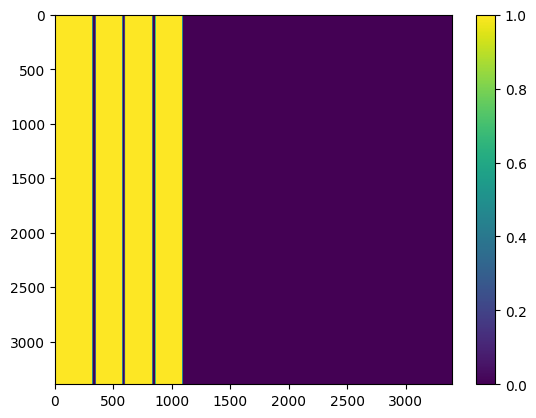

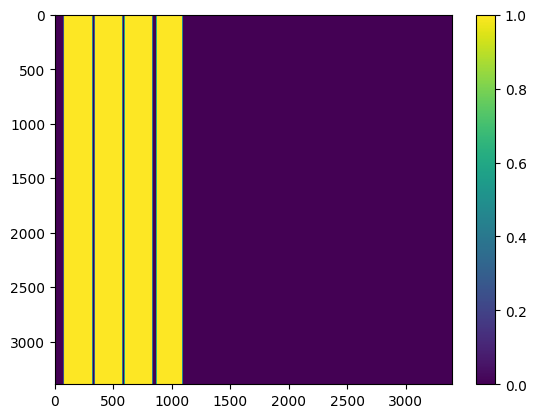

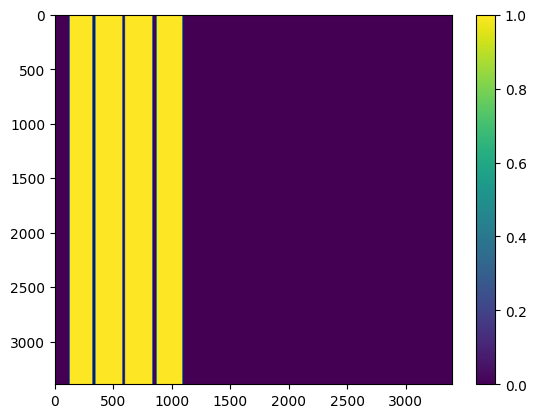

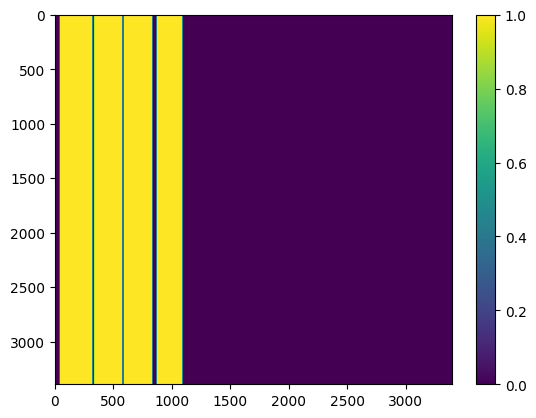

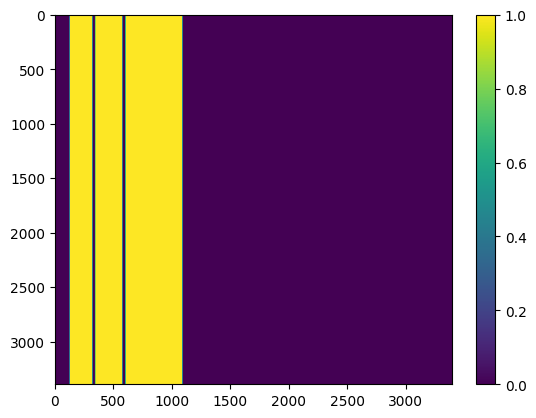

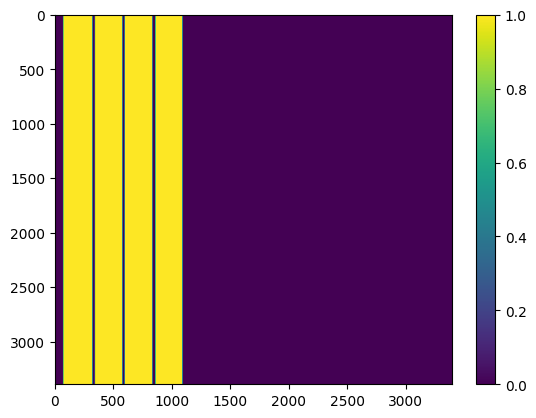

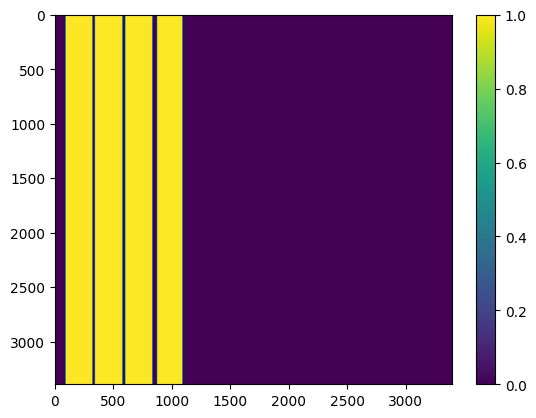

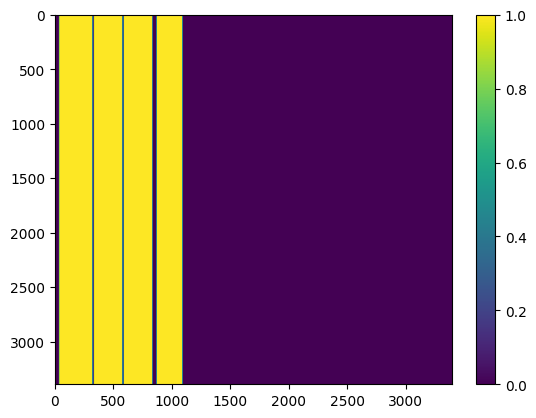

In [33]:
from einops import repeat
key_padding_mask = repeat(padding, "b i -> b h j i", h=doom.heads, j=doom.zorro_mask.shape[-2])
for i in range(8):
    plt.figure(i)
    plt.imshow(key_padding_mask[i,7,:,:], aspect = 'auto')
    plt.colorbar()

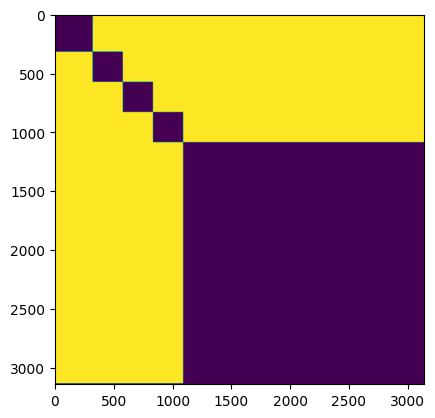

In [172]:
plt.imshow(doom.zorro_mask)

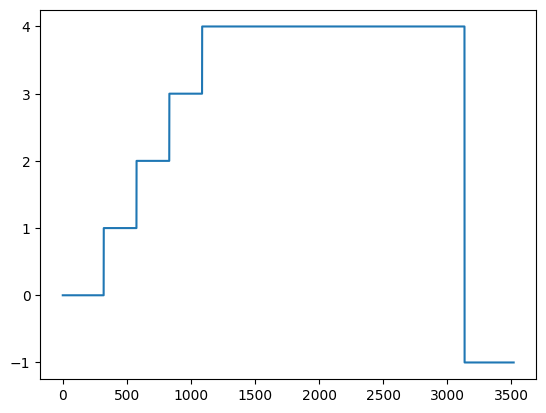

In [204]:
plt.plot(doom.token_types)

In [207]:
def create_mfdoom_pooling_mask(token_types, 
                               return_token_types_tensor, 
                               pool_mask):
    print(token_types)
    unique_tokens = torch.unique(token_types)
    assert doom.num_fusion_tokens % len(unique_tokens) == 0
    nsubtok = int(doom.num_fusion_tokens / len(unique_tokens))
    # MFDOOM pooling mask
    fusion_blocks = [torch.ones((1, nsubtok)) 
                     for _ in range(len(unique_tokens))]
    mfdoom_pool_mask = torch.block_diag(*fusion_blocks)
    #return mfdoom_pool_mask
    select_mask = (return_token_types_tensor == doom.fusion_token).unsqueeze(1) * \
                  (token_types == doom.fusion_token).unsqueeze(0)
    #return select_mask
    pool_mask[select_mask] = mfdoom_pool_mask.to(torch.bool).flatten()
    return pool_mask

tensor([ 0,  0,  0,  ..., -1, -1, -1])


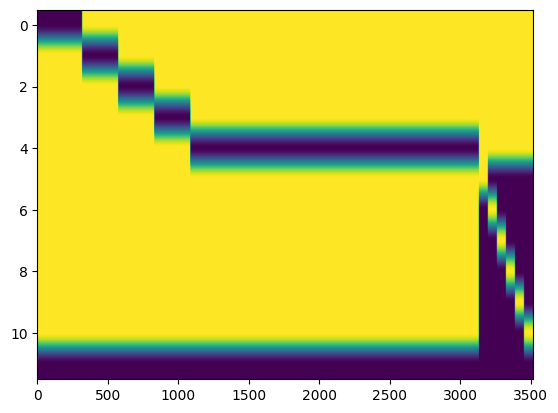

In [208]:
doom_pool_mask = create_mfdoom_pooling_mask(doom.token_types, doom.return_token_types_tensor, doom.pool_mask)
plt.imshow(doom_pool_mask, aspect="auto")

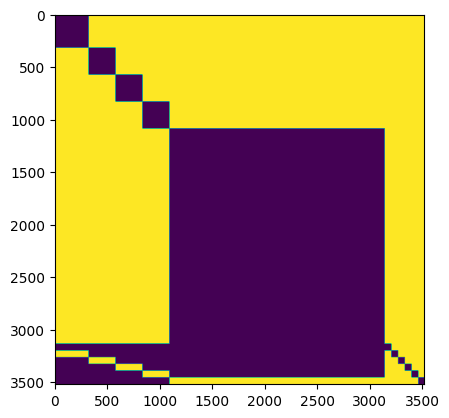

In [132]:
doom_mask = create_mfdoom_mask(doom.token_types, doom.zorro_mask)
plt.imshow(doom_mask)

In [11]:
import matplotlib.pyplot as plt
import torch
from einops import repeat
#plt.imshow(~pool, aspect='auto')
plt.clf()
heads = 4
bs = 8
sim = repeat(torch.ones_like(zorro), "i j -> b h i j", h = heads, b = bs)
sim = sim.masked_fill(zorro, 0)
key_padding_mask = repeat(pad, "b i -> b h j i", h=heads, j=sim.shape[-2])
sim = sim.masked_fill(key_padding_mask, 0)
sim
for i in range(8):
    plt.figure(i)
    plt.imshow(sim[i,0,:,:], aspect = 'auto')
    plt.colorbar()

NameError: name 'zorro' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.imshow(zorro)
doom(next(dl_iter))

In [ ]:
2048+256+256+128+320+16-3152

In [ ]:
fs = frozenset({'a','b'})
#a,b =x
a,b = fs
test2(a,b)

In [ ]:
def test(x):
    return x+'_'
def test2(a,b):
    print(a + '---' + b)
test2(*[test(x) for x in fs])

In [36]:
from accelerate import Accelerator
accelerator = Accelerator()

/shared/miniconda3/envs/stp/lib/python3.9/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [39]:
accelerator.load_state('/efs-private/multimodal/training_outputs/training_output_00_26_09_11_2023')

In [38]:
!ls /efs-private/multimodal/training_outputs/training_output_00_26_09_11_2023

config.yaml	   random_states_0.pkl	random_states_5.pkl
model.safetensors  random_states_1.pkl	random_states_6.pkl
model_config.json  random_states_2.pkl	random_states_7.pkl
optimizer.bin	   random_states_3.pkl	scheduler.bin
pytorch_model.bin  random_states_4.pkl


In [45]:
!pip install safetensors

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [54]:
import torch
from safetensors.torch import load_file

In [63]:
t = load_file('/efs-private/multimodal/training_output_06_39_09_12_2023/0/model.safetensors')

In [64]:
t

{'attn_pool.norm.beta': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.,

In [86]:
max([len(x['tokens']) for x in dataset['en'][:]])

251

(array([2.3660e+03, 1.8330e+03, 2.7200e+03, 3.7230e+03, 1.1042e+04,
        6.8680e+03, 7.0630e+03, 7.2190e+03, 1.4278e+04, 6.8820e+03,
        6.9630e+03, 6.6470e+03, 1.2564e+04, 5.8550e+03, 5.5450e+03,
        5.3510e+03, 9.7710e+03, 4.4440e+03, 4.1360e+03, 4.0820e+03,
        7.3120e+03, 3.4300e+03, 3.1100e+03, 2.8710e+03, 5.3700e+03,
        2.4230e+03, 2.3040e+03, 2.1080e+03, 3.6880e+03, 1.6490e+03,
        1.5370e+03, 1.3610e+03, 2.5860e+03, 1.1110e+03, 1.0160e+03,
        9.8100e+02, 1.7270e+03, 7.3300e+02, 7.3800e+02, 6.6200e+02,
        1.2240e+03, 5.0400e+02, 4.9000e+02, 4.3500e+02, 8.1400e+02,
        3.2800e+02, 2.8100e+02, 2.9600e+02, 5.6800e+02, 2.2600e+02,
        2.3200e+02, 2.0100e+02, 3.8800e+02, 1.5500e+02, 1.5300e+02,
        1.7200e+02, 2.6400e+02, 1.1300e+02, 1.0200e+02, 1.1900e+02,
        1.9200e+02, 7.2000e+01, 2.0400e+02, 6.7000e+01, 1.2700e+02,
        6.9000e+01, 6.0000e+01, 4.7000e+01, 1.2600e+02, 5.2000e+01,
        4.2000e+01, 4.4000e+01, 7.4000e+01, 3.80

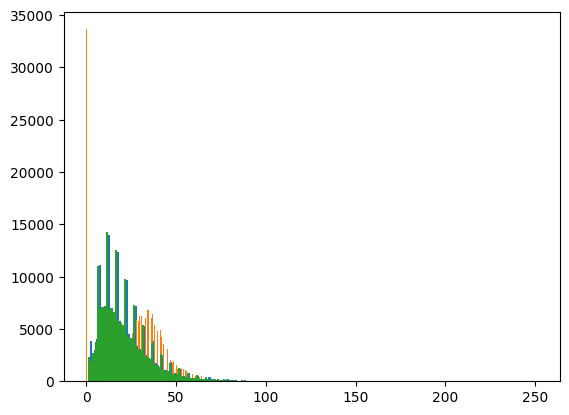

In [84]:
plt.hist([len(x['tokens']) for x in dataset['en'][:]], bins=200)
plt.hist([len(x['tokens']) for x in dataset['sm'][:]], bins=200)
plt.hist([len(x['tokens']) for x in dataset['pt'][:]], bins=200)

In [85]:
print(dataset['en'][0]['tokens'].shape)
print(dataset['pt'][0]['tokens'].shape)
print(dataset['sm'][0]['tokens'].shape)


torch.Size([24])
torch.Size([27])
torch.Size([49])


In [148]:
x=next(dl_iter)['sm']['tokens']
[x[i,:].count_nonzero() for i in range(x.shape[0])]

[tensor(33),
 tensor(37),
 tensor(31),
 tensor(45),
 tensor(57),
 tensor(0),
 tensor(31),
 tensor(0)]

In [170]:
aud_tokens = []
for i in range(10000):
    aud_tokens += ((next(dl_iter)['aud']['values'] != -10000).sum(dim=1)[:,0]/32).tolist()

(array([24009., 18264., 13888.,  9047.,  5694.,  3465.,  2032.,  1288.,
          873.,  1440.]),
 array([ 0. ,  6.4, 12.8, 19.2, 25.6, 32. , 38.4, 44.8, 51.2, 57.6, 64. ]),
 <BarContainer object of 10 artists>)

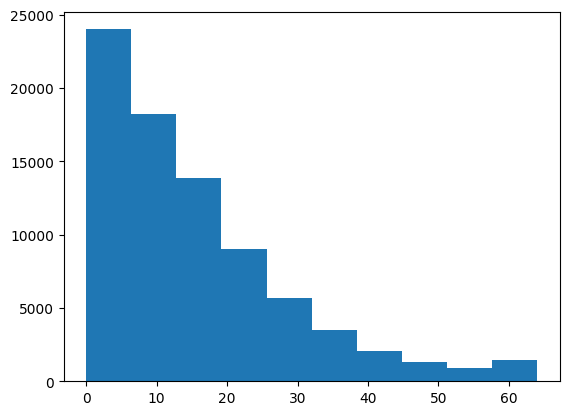

In [171]:
plt.hist(aud_tokens)

In [174]:
torch.cuda.current_device()

RuntimeError: No CUDA GPUs are available